# A/B test analysis for online shop

**Project objectives**

-  hypotheses prioritization from the list.

- analysis of the results of A/B test.

**Input data**

*list of hypotheses (hypothesis.csv file)*

- Hypothesis — a brief description of the hypothesis;
- Reach — user coverage  10-point scale;
- Impact — impact on users  10-point scale;
- Confidence — confidence in the hypothesis  10-point scale;
- Efforts — the cost of resources to test the hypothesis  10-point scale.

*information about user orders in the online store (orders.csv file.)*
- TransactionID - order ID;
- visitorID — ID of the user who made the order;
- date — the date when the order was made;
- revenue — order revenue;
- group — the A/B test group that the order fell into.

*information about user visits to the online store (visitors.csv file)*
- date - date;
- group — A/B test group;
- visitors — the number of users on the specified date in the specified A/B test group.

## Data overview and wrangling

###  Data overview 

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import scipy.stats as stats
import warnings
from scipy import stats as st



In [2]:
# removing the limit on the number of columns
pd.set_option('display.max_columns', None)

# removing the restriction on the width of columns
pd.set_option('display.max_colwidth', None)

# ignore warnings
pd.set_option('chained_assignment', None)

 # limit on the number of decimal places
pd.options.display.float_format = '{:,.2f}'.format

plt.style.use('seaborn-muted') 

sns.set(rc={'figure.figsize':(15,8)})

In [3]:
# reading data files and saving to df

hypothesis, orders, visitors = (
        pd.read_csv('hypothesis.csv'),
        pd.read_csv('orders.csv'),
        pd.read_csv('visitors.csv'))

In [4]:
# overview of dataset hypothesis
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [5]:
# overview of dataset orders

orders.info()
orders.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
511,1393848137,3874092616,2019-08-06,17379,B
784,1183827418,3573155649,2019-08-07,4990,B
546,2866469834,3917749921,2019-08-29,3950,B
414,2505918657,2524310328,2019-08-06,270,B
320,1652782757,2763027084,2019-08-19,1460,B


In [6]:
# overview of dataset visitors

visitors.info()
visitors.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
37,2019-08-07,B,709
17,2019-08-18,A,668
0,2019-08-01,A,719
14,2019-08-15,A,628
58,2019-08-28,B,654


### Data wrangling

In [7]:
# changing name of columns

hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = [name.replace('Id', '_id') for name in orders.columns]


In [8]:
hypothesis.columns


Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

In [9]:
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [10]:
# changing data types

visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

In [11]:
orders.duplicated().sum()

0

In [12]:
visitors.duplicated().sum()

0

In [13]:
#function for translation column
from googletrans import Translator
translator = Translator()
def transate_column(df, column_name):
    for index, row in df.iterrows():
        result=translator.translate(row[column_name],src='ru',dest='en')
        df.at[index, column_name] = result.text
    return df

In [14]:
# translating column via Google translate
hypothesis= transate_column(hypothesis,'hypothesis')

In [15]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Add two new channels to attract traffic, which will attract 30% more users",3,10,8,6
1,"Launch your own delivery service, which will reduce the delivery time of orders",2,5,4,10
2,Add product recommendation blocks to the online store website to increase conversion and average check of the order,8,3,7,3
3,"Change the structure of categories, which will increase the conversion, because. users will find the right product faster",8,3,3,8
4,Change the background color of the main page to increase user engagement,3,1,1,1
5,"Add a customer reviews page about the store, which will increase the number of orders",3,2,2,3
6,Display banners with current promotions and sales on the main page to increase conversion,5,3,8,3
7,Add a subscription form to all main pages to build a customer base for email newsletters,10,7,8,5
8,Launch a promotion that gives a discount on goods on your birthday,1,9,9,5


**Conclusion:**

The following data were provided for analysis and the following operations were performed:

list of hypotheses (hypothesis.csv file) - contains 9 lines with the names of hypotheses and their evaluation, no repetitions and duplicates were found, names of the columns are correct. The hypothesis names were translated.

information about user orders in the online store (orders.csv.file) - 1197 rows and 5 columns, no duplicates or duplicates were found, the columns' names are correct.

information about user visits to the online store (visitors.csv file) - 62 rows and 3 columns, no repetitions and duplicates were found, the columns' names are correct.

##  Hypotheses prioritization 

*The following tasks must be completed:*

- Apply the ICE framework to prioritize hypotheses. Sort them in descending order of priority.
- Apply the RICE framework to prioritize hypotheses. Sort them in descending order of priority.
- Indicate how the prioritization of hypotheses has changed when using RICE instead of ICE. Explain why this happened.


In [16]:
#creating ICE column
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False)

,hypothesis,ice
8,Launch a promotion that gives a discount on goods on your birthday,16.20
0,"Add two new channels to attract traffic, which will attract 30% more users",13.33
7,Add a subscription form to all main pages to build a customer base for email newsletters,11.20
6,Display banners with current promotions and sales on the main page to increase conversion,8.00
2,Add product recommendation blocks to the online store website to increase conversion and average check of the order,7.00
1,"Launch your own delivery service, which will reduce the delivery time of orders",2.00
5,"Add a customer reviews page about the store, which will increase the number of orders",1.33
3,"Change the structure of categories, which will increase the conversion, because. users will find the right product faster",1.12
4,Change the background color of the main page to increase user engagement,1.00


In [17]:
# creating RICE column
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
7,Add a subscription form to all main pages to build a customer base for email newsletters,112.00
2,Add product recommendation blocks to the online store website to increase conversion and average check of the order,56.00
0,"Add two new channels to attract traffic, which will attract 30% more users",40.00
6,Display banners with current promotions and sales on the main page to increase conversion,40.00
8,Launch a promotion that gives a discount on goods on your birthday,16.20
3,"Change the structure of categories, which will increase the conversion, because. users will find the right product faster",9.00
1,"Launch your own delivery service, which will reduce the delivery time of orders",4.00
5,"Add a customer reviews page about the store, which will increase the number of orders",4.00
4,Change the background color of the main page to increase user engagement,3.00


In [18]:
# looking at final table
hypothesis[['hypothesis','ice', 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,ice,rice
7,Add a subscription form to all main pages to build a customer base for email newsletters,11.20,112.00
2,Add product recommendation blocks to the online store website to increase conversion and average check of the order,7.00,56.00
0,"Add two new channels to attract traffic, which will attract 30% more users",13.33,40.00
6,Display banners with current promotions and sales on the main page to increase conversion,8.00,40.00
8,Launch a promotion that gives a discount on goods on your birthday,16.20,16.20
3,"Change the structure of categories, which will increase the conversion, because. users will find the right product faster",1.12,9.00
1,"Launch your own delivery service, which will reduce the delivery time of orders",2.00,4.00
5,"Add a customer reviews page about the store, which will increase the number of orders",1.33,4.00
4,Change the background color of the main page to increase user engagement,1.00,3.00


The same hypotheses are in reverse order for ICE and RICE. The difference in prioritization lies in the Reach parameter - the number of users who will be affected by the changes.

## A/B-test analysis


We have results of A/B in the files ab-orders.csv and ab-visitors.csv. First of all,it is necessary to check if there are no users who are in both groups at the same time.

In [19]:
# creating pivot table
doubles = orders.groupby(['visitor_id']).agg({'group' : 'nunique', 'transaction_id' : 'count', 'revenue' : 'sum'}).reset_index()

In [20]:
# number of users that are present in both groups
doubles[doubles.group != 1]["visitor_id"].count()

58

In [21]:
# removing duplicates
d_list = list(doubles[doubles.group != 1]['visitor_id'])
orders = orders.query('visitor_id not in @d_list')

### Cumulative metrics calculation

In [22]:
# creating an array of unique pairs of date values and test groups
dates_grouped = orders[['date', 'group']].drop_duplicates()

# we get aggregated cumulative data on orders by days
orders_grouped = dates_grouped.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

orders_grouped.head()

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


In [23]:
# aggregated cumulative data of the visitors  by days

visitors_grouped = dates_grouped.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max', 
            'group': 'max', 
            'visitors': 'sum'
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitors_grouped.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [24]:
#cumulative data in one table and assigning clear names to columns

cumulative_data = orders_grouped.merge(
    visitors_grouped, 
    left_on=['date', 'group'], 
    right_on=['date', 'group']
)

cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [25]:
# adding a column with the number of orders per user
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.03
1,2019-08-01,B,17,17,59758,713,0.02
2,2019-08-02,A,42,36,234381,1338,0.03
3,2019-08-02,B,40,39,221801,1294,0.03
4,2019-08-03,A,66,60,346854,1845,0.04


###  Revenue by groups

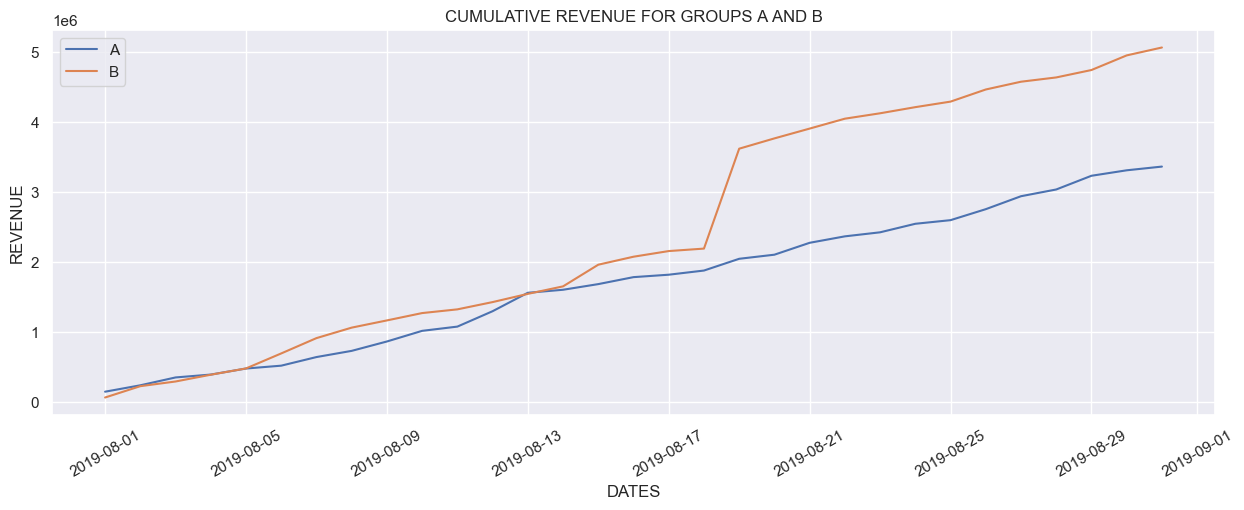

In [26]:
# for group A
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# for group B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.title('CUMULATIVE REVENUE FOR GROUPS А AND В')
plt.ylabel("REVENUE")
plt.xlabel("DATES")
plt.xticks(rotation=30)
plt.legend()
plt.show()

### Cumulative average revenue


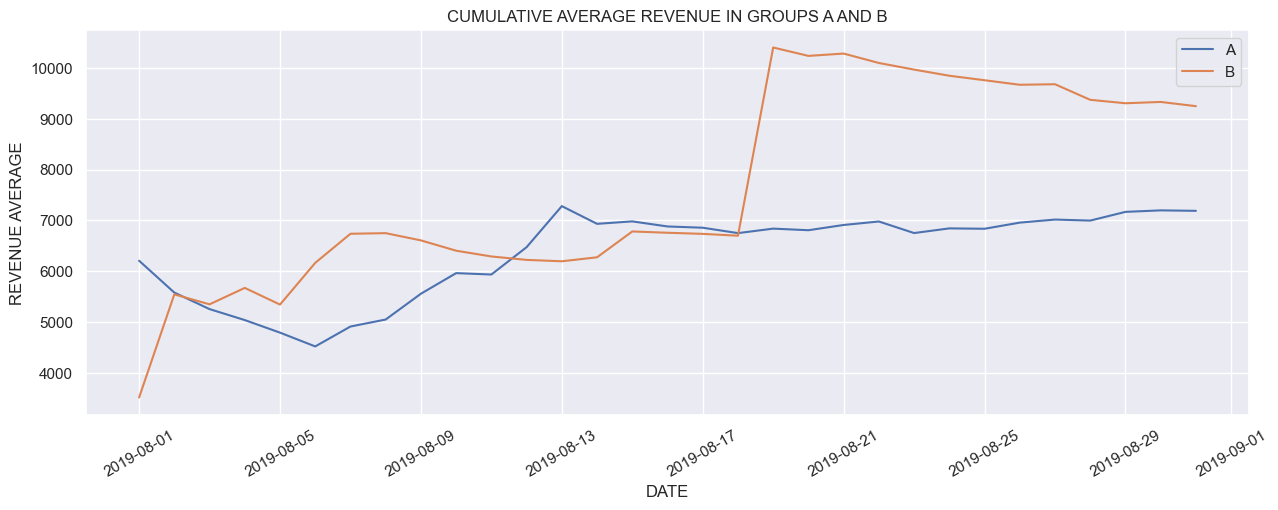

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(cumulative_revenue_a['date'], 
         cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'],
         label='A')

plt.plot(cumulative_revenue_b['date'], 
         cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders'], 
         label='B')

plt.title('CUMULATIVE AVERAGE REVENUE IN GROUPS A AND B')
plt.ylabel("REVENUE AVERAGE")
plt.xlabel("DATE")
plt.xticks(rotation=30)
plt.legend()
plt.show()

### Relative average revenue of group B in comparison to group A

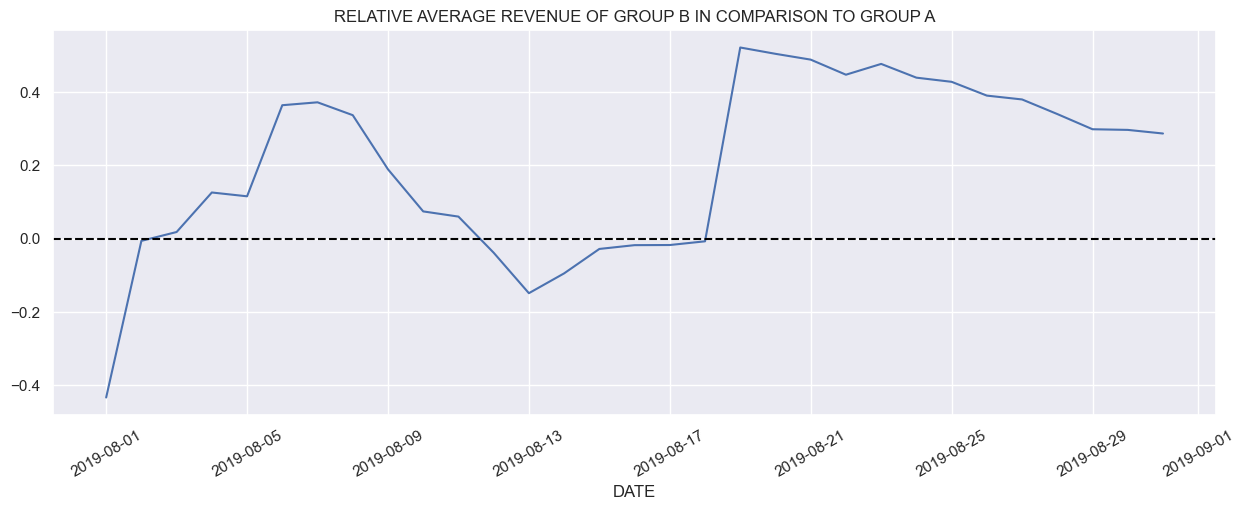

In [28]:
# creating dataframe
cumulative_revenue_ab = cumulative_revenue_a.merge(
    cumulative_revenue_b, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['_a', '_b']
)

# creating graphic
fig, ax = plt.subplots(figsize=(15, 5))

plt.plot(cumulative_revenue_ab['date'], 
         (
             cumulative_revenue_ab['revenue_b']/cumulative_revenue_ab['orders_b']
         )/
         (
             cumulative_revenue_ab['revenue_a']/cumulative_revenue_ab['orders_a']
         )-1
        )

# adding X axis
plt.axhline(y=0, color='black', linestyle='--')
plt.title('RELATIVE AVERAGE REVENUE OF GROUP B IN COMPARISON TO GROUP A')
plt.xlabel("DATE")
plt.xticks(rotation=30)
plt.show()

The charts change dramatically in several dates. It can be assumed that there are some large orders.

### Cumulative number of orders per user

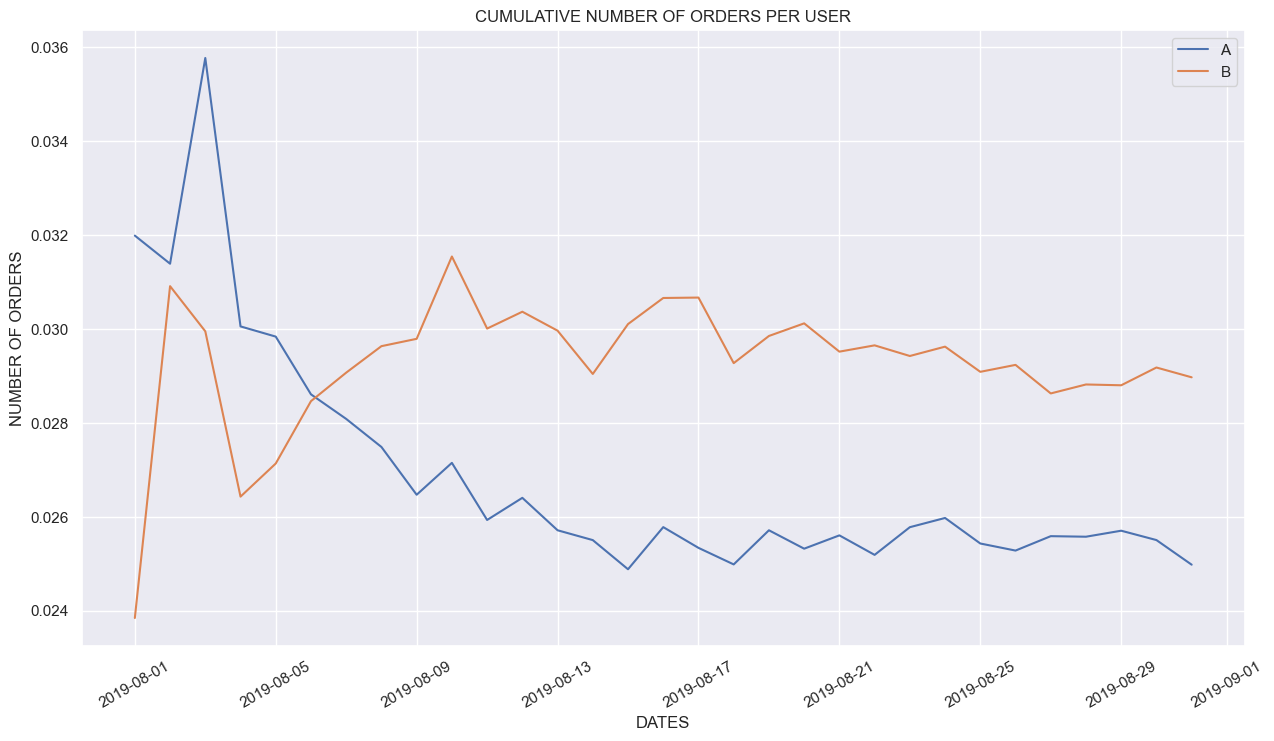

In [29]:
# group A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# group B 
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# building graphics
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()
plt.title('CUMULATIVE NUMBER OF ORDERS PER USER')
plt.xlabel('DATES')
plt.ylabel('NUMBER OF ORDERS')
plt.xticks(rotation=30)
plt.show()

The cumulative number of Group B orders is definitely better than the cumulative number of Group A orders.

### Relative cumulative number of orders per user of group B in comparison to group A

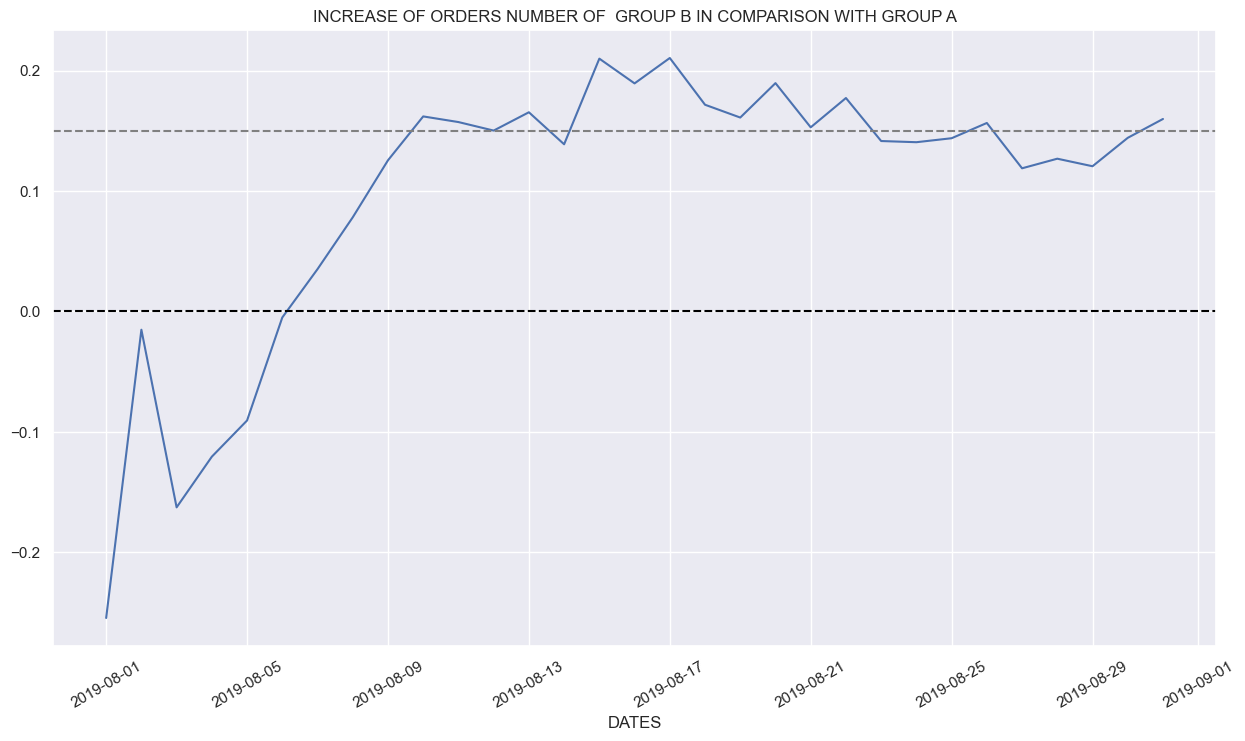

In [30]:
cumulative_conversions_ab = (
    cumulative_data_a[['date','conversion']]
    .merge(
        cumulative_data_b[['date','conversion']], 
        left_on='date', 
        right_on='date', 
        how='left', 
        suffixes=['_a', '_b']
    )
)
plt.plot(
    cumulative_conversions_ab['date'], 
    cumulative_conversions_ab['conversion_b']/
    cumulative_conversions_ab['conversion_a']-1
)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.title('INCREASE OF ORDERS NUMBER OF  GROUP B IN COMPARISON WITH GROUP A')
plt.xlabel('DATES')
plt.xticks(rotation=30)
plt.show()

The graphs obtained above showed the presence of large orders. There are definitely outliers in the data.


###  Orders per user

In [31]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns =  ['visitor_id', 'orders']
display(orders_by_users['orders'].describe())

count   973.00
mean      1.04
std       0.24
min       1.00
25%       1.00
50%       1.00
75%       1.00
max       3.00
Name: orders, dtype: float64

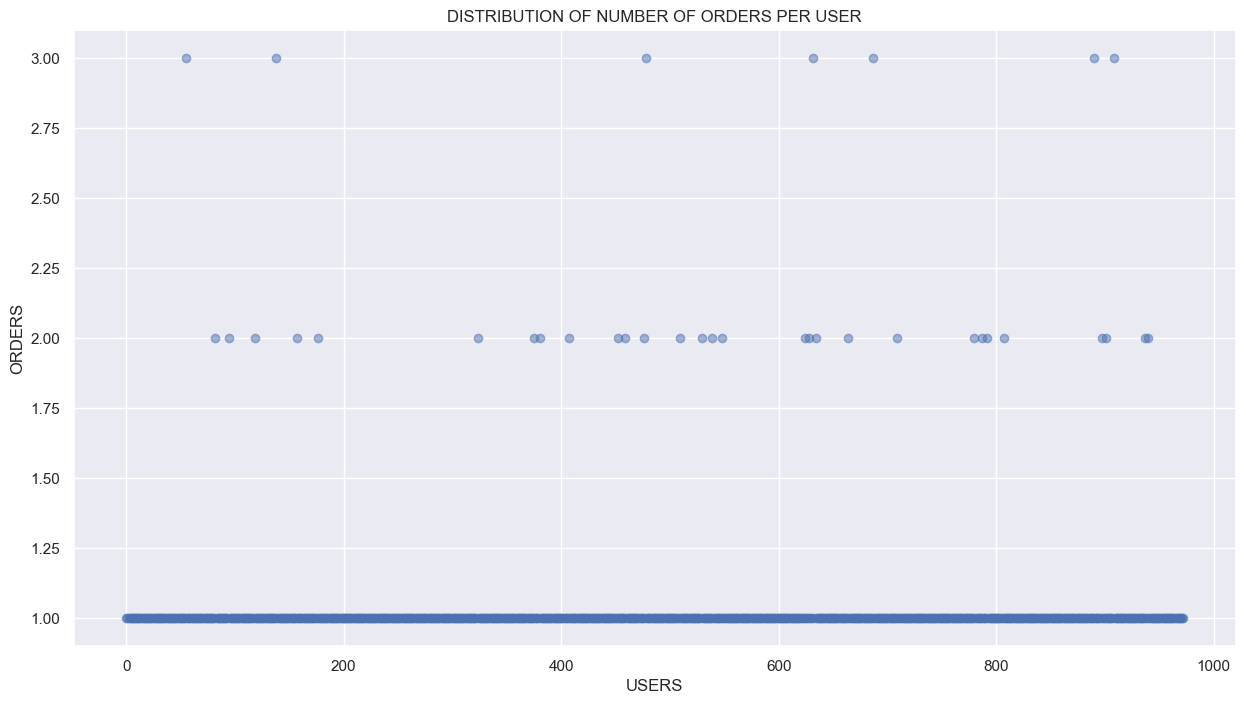

In [32]:
x_values = pd.Series(range(0,len(orders_by_users)))

# building scatter
plt.scatter(x_values, orders_by_users['orders'], alpha=0.5)
plt.title('DISTRIBUTION OF NUMBER OF ORDERS PER USER')
plt.xlabel("USERS")
plt.ylabel("ORDERS")
plt.show()

Most users have placed an order once, there are also users who placed 2-4 orders for. The maximum number of orders is 11.

### Percentile of orders per user

In [33]:
np.percentile(orders_by_users['orders'], [95, 99])

array([1., 2.])

Only 1 percent of users order more than once.

### Revenue

In [34]:
orders['revenue'].describe()

count       1,016.00
mean        8,300.81
std        42,121.99
min            50.00
25%         1,190.00
50%         2,955.00
75%         8,134.25
max     1,294,500.00
Name: revenue, dtype: float64

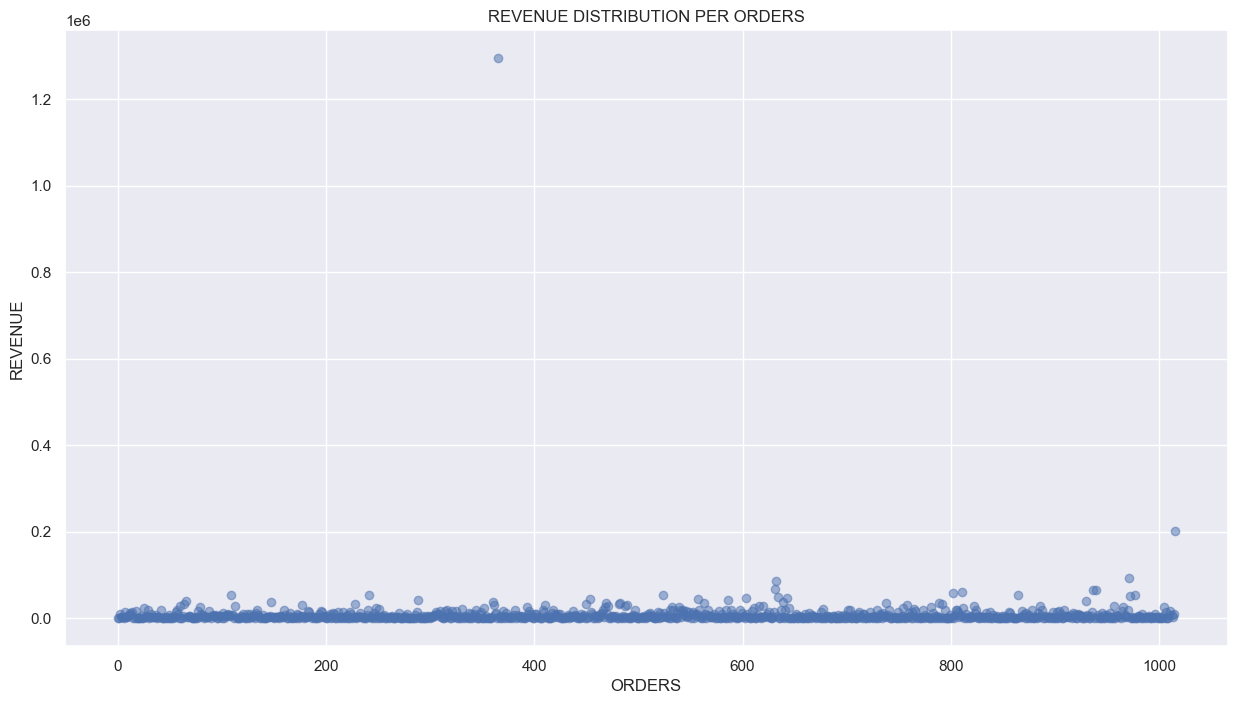

In [35]:
x_values = pd.Series(range(0,len(orders['revenue'])))

# building scatter diagram
plt.scatter(x_values, orders['revenue'], alpha=0.5)
plt.title('REVENUE DISTRIBUTION PER ORDERS')
plt.xlabel("ORDERS")
plt.ylabel("REVENUE")
plt.show()

One order is almost 1.3 million. Presumably, it caused a spike in the graphs of cumulative metrics.
Let's build a graph without it.

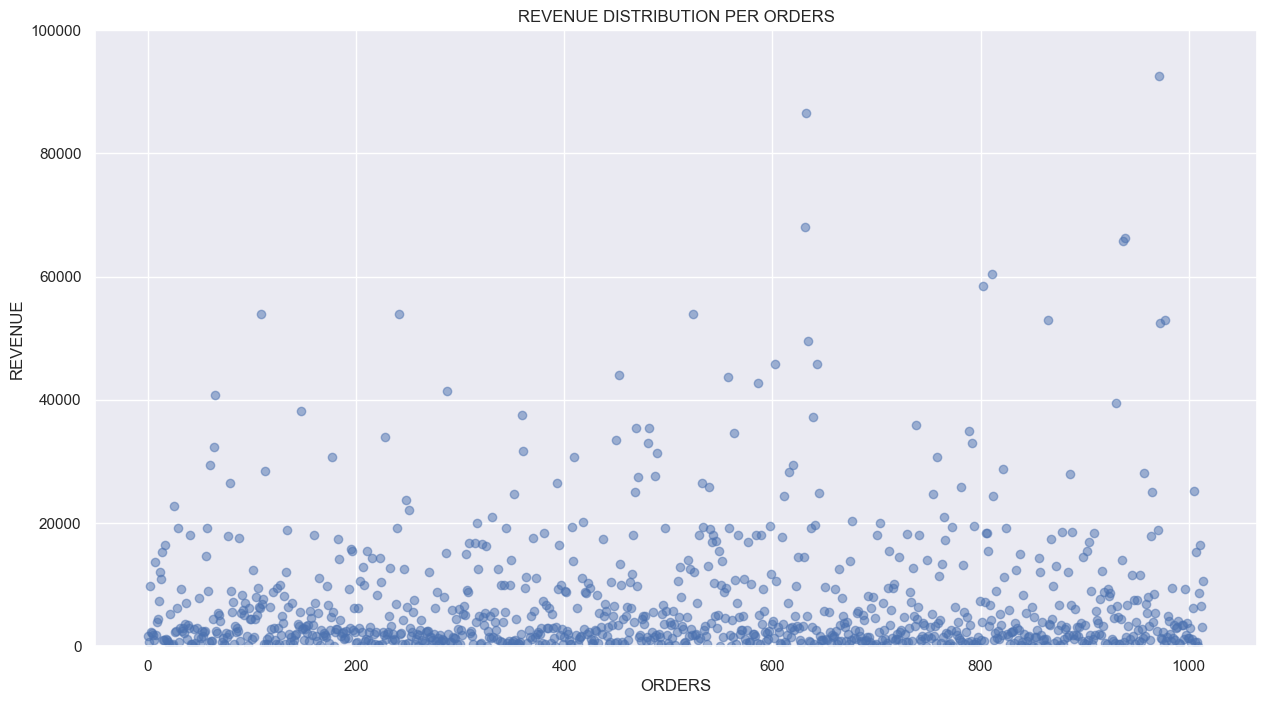

In [36]:

plt.ylim(0, 100000)
plt.scatter(x_values, orders['revenue'], alpha=0.5)
plt.title('REVENUE DISTRIBUTION PER ORDERS')
plt.xlabel("ORDERS")
plt.ylabel("REVENUE")
plt.show()

Most of the orders are no more than 20000-25000.

### Revenue percentile

In [37]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

Only one percent of users ordered for mor than 53904.

### Analysis of statistical significance

The results of the A/B test showed that there are outliers in the data.

Calculating statistical significance of differences between groups based on "raw" data — without removing abnormal users.

**Let's formulate null and alternative hypothesis.**

H0- there is no difference in orders per user.

H1- there is no difference in orders per user.

critical level of statistical significance of 0.05

Since data on sales and average receipts are rarely normally distributed (this is a classic example of variables subject to outliers), we will use the nonparametric Mann-Whitney test for hypotheses.

*Preparing the data and creating a table with the following columns for the test:*

date;

orders_daily_a;

revenue_per_date_a;

orders_daily_a;

revenue_per_date_a;

orders_cummulative_a;

revenue_cummulative_a;

orders_cummulative_b;

revenue_cummulative_b;

visitors_per_date_a;

visitors_per_date_b;

visitors_cummulative_a;

visitors_cummulative_b.

In [38]:
visitors_daily_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_a.columns = ['date', 'visitors_per_date_a']

visitors_cummulative_a = visitors_daily_a.apply(
    lambda x: visitors_daily_a[visitors_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_cummulative_a.columns = ['date', 'visitors_cummulative_a']

visitors_daily_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_b.columns = ['date', 'visitors_per_date_b']

visitors_cummulative_b = visitors_daily_b.apply(
    lambda x: visitors_daily_b[visitors_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_cummulative_b.columns = ['date', 'visitors_cummulative_b']

orders_daily_a = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_a.columns = ['date', 'orders_daily_a', 'revenue_per_date_a']

orders_cummulative_a = orders_daily_a.apply(
    lambda x: orders_daily_a[orders_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cummulative_a.columns = ['date','orders_cummulative_a','revenue_cummulative_a']

orders_daily_b = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_b.columns = ['date', 'orders_daily_b', 'revenue_per_date_b']

orders_cummulative_b = orders_daily_b.apply(
    lambda x: orders_daily_b[orders_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cummulative_b.columns = ['date','orders_cummulative_b','revenue_cummulative_b']


data = (
    orders_daily_a.merge(
        orders_daily_b, left_on='date', right_on='date', how='left'
    )
    .merge(orders_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(orders_cummulative_b, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_a, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_b, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_b, left_on='date', right_on='date', how='left')
)
data.head()

,date,orders_daily_a,revenue_per_date_a,orders_daily_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


### Statistical significant difference in the average number of orders per visitor between groups based on "raw" data

Creating dataset order_by_users_a and order_by_users_b; for users who ordered at least 1 time, specifing the number of completed orders.

In [39]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

Let's declare the variables sample_a and sample_b, in which the number of orders will correspond to users from different groups. Those who have not ordered anything will be matched with zeros. This is necessary in order to prepare the samples for verification by the criterion.



In [40]:
sample_a = pd.concat([orders_by_users_a['orders'],
                      pd.Series(
                          0, 
                          index=np.arange(data['visitors_per_date_a'].sum() - 
                                          len(orders_by_users_a['orders'])), 
                          name='orders')],axis=0
                    )

sample_b = pd.concat([orders_by_users_b['orders'],
                      pd.Series(
                          0, 
                          index=np.arange(data['visitors_per_date_b'].sum() - 
                                          len(orders_by_users_b['orders'])), 
                          name='orders')],axis=0
                    )

*Defining function:*

setting the significance level alpha=0.05,

setting  the Mann-Whitney test,

formatting the p-value by rounding it to three decimal places,

calculating relative increase.    

In [41]:

def stat_significance(data_a, data_b):
    alpha = 0.05
    p_value = stats.mannwhitneyu(data_a, data_b)[1]
    print("P-value: {0:.3f}".format(p_value))

    if (p_value < alpha):
        print('Rejecting H0: there is a significant statistical difference between the groups')
    else:
        print('Rejecting H0 was not succesful, we can not consider that there is a significant statistical difference between the groups')
    
    print("Relative increase В to А: {0:.3%}".format(data_b.mean() / data_a.mean()-1))

In [42]:
stat_significance(sample_a, sample_b)

P-value: 0.011
Rejecting H0: there is a significant statistical difference between the groups
Relative increase В to А: 15.980%


### Statistical significant difference in the average revenue between groups for "raw" data

Let's calculate statistical significant difference in the average revenue between groups for "raw" data — without removing abnormal users.

the main and alternative hypotheses:

- H0- there are no differences between the groups in the average revenue

- H1- there are differences between groups in the average revenue

alpha =0.05

In [43]:
stat_significance(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])

P-value: 0.829
Rejecting H0 was not succesful, we can not consider that there is a significant statistical difference between the groups
Relative increase В to А: 28.660%


### Statistic significance of differences in the average number of orders per visitor between groups for clean data

Finding users with the largest number and most expensive orders.

In [44]:
many_orders = np.percentile(orders_by_users['orders'], 99)
expensive_orders = np.percentile(orders['revenue'], 99)


users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > many_orders]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > many_orders]['visitor_id'],
    ],
    axis=0,
)


users_with_expensive_orders = orders[orders['revenue'] > expensive_orders]['visitor_id']


abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormal_users.head(15))

abnormal_users.shape[0]


1099     148427295
33       249864742
58       611059232
949      887908475
744      888512513
1103    1164614297
1136    1307669133
425     1920142716
1196    2108080724
211     2108163459
347     2742574263
310     2988190573
409     3908431265
416     3967698036
940     4003628586
Name: visitor_id, dtype: int64

16

Cleaning data.

In [45]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


Let's calculate statistical significant difference in in the average number of orders per visitor between groups for "clean" data — after removal of abnormal users.

The main and alternative hypotheses:

H0- there are no differences between groups in the average number of orders per visitor

H1- there are differences between groups in the average number of orders per visitor

alpha =0.05

In [46]:
# using previous function

stat_significance(sample_a_filtered, sample_b_filtered)

P-value: 0.007
Rejecting H0: there is a significant statistical difference between the groups
Relative increase В to А: 18.921%


In [47]:
#remembering raw data calculation for the same hypothesis
stat_significance(sample_a, sample_b)

P-value: 0.011
Rejecting H0: there is a significant statistical difference between the groups
Relative increase В to А: 15.980%


For both groups, based on raw and clean data, we rejected the null hypothesis that there is no difference between difference between the groups in the average number of orders per visitor. The relative increase in B to A is: 18.921% - for raw data and 15.980% -for clean data (increased by ~3% for clean data).

### Statistical significant difference in the average revenue between groups for clean data

Let's calculate statistical significant difference in the average revenue after the removal of abnormal users.

the main and alternative hypotheses:

H0- there are no differences between the groups in the average revenue

H1- there are differences between the groups in the average revenue

alpha =0.05

In [48]:
#for clean data
stat_significance(
    orders[(orders['group']=='A') & np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue'], 
    orders[(orders['group']=='B') & np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue']
                  )

P-value: 0.788
Rejecting H0 was not succesful, we can not consider that there is a significant statistical difference between the groups
Relative increase В to А: -3.234%


In [49]:
#for raw data

stat_significance(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])

P-value: 0.829
Rejecting H0 was not succesful, we can not consider that there is a significant statistical difference between the groups
Relative increase В to А: 28.660%


For both groups for the raw and purified data we could not reject the null hypothesis about the absence of a difference in the average revenue. 

## Conclusion

**Data:**

- list of hypotheses (file hypothesis.csv)
- information about user orders in the online store (file orders.csv.)
- information about user visits to the online store (file visitors.csv)

**Conclusion for prioritization of hypotheses:**

*The best hypotheses are as follows:*

- "Launch a promotion giving a discount on a product on your birthday"
- "Add two new traffic channels, which will attract 30% more users"
- "Add a subscription form to all the main pages to collect a customer base for email newsletters"

* But! if user coverage of users should be taken into account, then the best hypotheses are the following:*

- "Add a subscription form to all the main pages to collect a customer base for email newsletters",
- "Add product recommendation blocks to the online store's website to increase conversion and average order receipt",
- "Add two new traffic channels, which will attract 30% more users."

**Conclusion for  A/B test analysis:**

- There is difference between groups in the average number of orders per user. The relative increase in group B is 16-19% for clean and raw data.
- There is no  statistical significant difference between the groups in the average revenue.
